In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ============================================================================
# 1. CONFIGURACIÓN DE HIPERPARÁMETROS (EXPERIMENTA AQUÍ)
# ============================================================================

print("🔧 CONFIGURACIÓN DE LA NEURONA RNN")
print("="*50)

# ⚠️ PARÁMETRO MÁS IMPORTANTE: LEARNING RATE (RATIO DE APRENDIZAJE)
LEARNING_RATE = 0.001      # 🎯 AJUSTA ESTE VALOR:
                          #    0.1    = MUY RÁPIDO (puede no converger)
                          #    0.01   = RÁPIDO (bueno para empezar)
                          #    0.001  = MODERADO (recomendado)
                          #    0.0001 = LENTO (más estable)

# ⚠️ OTROS PARÁMETROS IMPORTANTES
EPOCHS = 50               # Número de veces que ve todos los datos
BATCH_SIZE = 16           # Cuántos ejemplos procesa a la vez
RNN_NEURONS = 32          # Número de neuronas en la RNN
DROPOUT_RATE = 0.2        # Para evitar sobreajuste (0.1-0.3)

# PARÁMETROS DE DATOS
DIAS_HISTORICOS = 30      # Días pasados para predecir
DIAS_PREDICCION = 6       # Días futuros a predecir

print(f"📊 Learning Rate: {LEARNING_RATE} ← CLAVE PARA EL APRENDIZAJE")
print(f"📊 Epochs: {EPOCHS}")
print(f"📊 Batch Size: {BATCH_SIZE}")
print(f"📊 Neuronas RNN: {RNN_NEURONS}")
print(f"📊 Dropout: {DROPOUT_RATE}")
print(f"📊 Días históricos: {DIAS_HISTORICOS}")
print(f"📊 Días a predecir: {DIAS_PREDICCION}")

🔧 CONFIGURACIÓN DE LA NEURONA RNN
📊 Learning Rate: 0.001 ← CLAVE PARA EL APRENDIZAJE
📊 Epochs: 50
📊 Batch Size: 16
📊 Neuronas RNN: 32
📊 Dropout: 0.2
📊 Días históricos: 30
📊 Días a predecir: 6


In [9]:
# ============================================================================
# 2. DESCARGA DE DATOS
# ============================================================================

print(f"\n📥 DESCARGANDO DATOS DE DOGECOIN...")
print("="*50)

# Descargamos los datos como especificaste
df = yf.download("DOGE-USD", start="2020-01-01", end="2024-12-31")


# Variable objetivo: CLOSE (como solicitaste)
precios_close = df['Close'].values

[*********************100%***********************]  1 of 1 completed


📥 DESCARGANDO DATOS DE DOGECOIN...


In [10]:
# ============================================================================
# 3. FUNCIÓN PARA CALCULAR MAPE
# ============================================================================

def calcular_mape(y_real, y_pred):
    """
    Calcula el Mean Absolute Percentage Error (MAPE)
    
    Args:
        y_real: Valores reales
        y_pred: Valores predichos
    
    Returns:
        mape: Error porcentual absoluto medio
    """
    return np.mean(np.abs((y_real - y_pred) / y_real)) * 100

In [11]:
# ============================================================================
# 4. NORMALIZACIÓN DE DATOS
# ============================================================================

print(f"\n🔄 NORMALIZANDO DATOS...")
print("="*50)

# Reshape para el scaler (necesita forma 2D)
precios_reshaped = precios_close.reshape(-1, 1)

# Normalizamos entre 0 y 1 (CRÍTICO para RNN)
scaler = MinMaxScaler(feature_range=(0, 1))
precios_normalizados = scaler.fit_transform(precios_reshaped)

print(f"✅ Datos normalizados")
print(f"📊 Rango original: ${precios_close.min():.6f} - ${precios_close.max():.6f}")
print(f"📊 Rango normalizado: {precios_normalizados.min():.3f} - {precios_normalizados.max():.3f}")



🔄 NORMALIZANDO DATOS...
✅ Datos normalizados
📊 Rango original: $0.001537 - $0.684777
📊 Rango normalizado: 0.000 - 1.000


In [12]:
# ============================================================================
# 5. FUNCIÓN PARA CREAR SECUENCIAS
# ============================================================================

def crear_secuencias(datos, dias_historicos, dias_prediccion):
    """
    Convierte series de tiempo en secuencias para RNN
    
    Args:
        datos: Array de precios normalizados
        dias_historicos: Cuántos días usar como entrada
        dias_prediccion: Cuántos días predecir
    
    Returns:
        X: Secuencias de entrada
        y: Secuencias objetivo
    """
    X, y = [], []
    
    # Creamos las secuencias deslizantes
    for i in range(len(datos) - dias_historicos - dias_prediccion + 1):
        # X: días históricos
        secuencia_entrada = datos[i:(i + dias_historicos)]
        X.append(secuencia_entrada)
        
        # y: días a predecir
        secuencia_objetivo = datos[(i + dias_historicos):(i + dias_historicos + dias_prediccion)]
        y.append(secuencia_objetivo)
    
    return np.array(X), np.array(y)

In [13]:
# ============================================================================
# 6. CREACIÓN DE SECUENCIAS
# ============================================================================

print(f"\n🔄 CREANDO SECUENCIAS DE ENTRENAMIENTO...")
print("="*50)

# Convertimos a secuencias
X, y = crear_secuencias(precios_normalizados.flatten(), DIAS_HISTORICOS, DIAS_PREDICCION)

print(f"✅ Secuencias creadas")
print(f"📊 Forma de X (entrada): {X.shape}")  # (muestras, tiempo, características)
print(f"📊 Forma de y (objetivo): {y.shape}")  # (muestras, días_predicción)
print(f"📊 Total de secuencias: {len(X)}")

# Reshape X para RNN (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)
print(f"📊 X reshape para RNN: {X.shape}")


🔄 CREANDO SECUENCIAS DE ENTRENAMIENTO...
✅ Secuencias creadas
📊 Forma de X (entrada): (1791, 30)
📊 Forma de y (objetivo): (1791, 6)
📊 Total de secuencias: 1791
📊 X reshape para RNN: (1791, 30, 1)


In [14]:
# ============================================================================
# 7. FUNCIÓN PARA CONSTRUIR LA NEURONA RNN
# ============================================================================

def construir_neurona_rnn():
    """
    Construye una neurona RNN simple
    
    Returns:
        model: Modelo RNN compilado
    """
    print(f"\n🧠 CONSTRUYENDO NEURONA RNN...")
    print("="*50)
    
    # Creamos el modelo secuencial
    model = Sequential()
    
    # Capa RNN Simple
    model.add(SimpleRNN(
        units=RNN_NEURONS,                    # Número de neuronas
        input_shape=(DIAS_HISTORICOS, 1),     # Forma de entrada
        return_sequences=False,               # Solo queremos la salida final
        activation='tanh'                     # Función de activación
    ))
    
    # Dropout para regularización
    model.add(Dropout(DROPOUT_RATE))
    
    # Capa de salida
    model.add(Dense(DIAS_PREDICCION, activation='linear'))
    
    # Compilamos con el learning rate especificado
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss='mse',           # Mean Squared Error
        metrics=['mae']       # Mean Absolute Error
    )
    
    print(f"✅ Neurona RNN construida")
    print(f"🔧 Arquitectura:")
    print(f"   - Entrada: {DIAS_HISTORICOS} días")
    print(f"   - RNN: {RNN_NEURONS} neuronas")
    print(f"   - Dropout: {DROPOUT_RATE}")
    print(f"   - Salida: {DIAS_PREDICCION} días")
    print(f"   - Learning Rate: {LEARNING_RATE}")
    
    return model

In [ ]:
# ============================================================================
# 8. FUNCIÓN DE EVALUACIÓN CON MAPE
# ============================================================================

def evaluar_modelo(model, X_test, y_test, nombre_evaluacion):
    """
    Evalúa el modelo y calcula métricas incluyendo MAPE
    
    Args:
        model: Modelo entrenado
        X_test, y_test: Datos de prueba
        nombre_evaluacion: Nombre descriptivo
    
    Returns:
        dict: Diccionario con métricas
    """
    print(f"\n📊 EVALUANDO: {nombre_evaluacion}")
    print("-" * 30)
    
    # Predicciones
    y_pred = model.predict(X_test, verbose=0)
    
    # Desnormalizamos para obtener precios reales
    y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
    y_pred_real = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)
    
    # Calculamos métricas
    mse = mean_squared_error(y_test_real, y_pred_real)
    mae = mean_absolute_error(y_test_real, y_pred_real)
    rmse = np.sqrt(mse)
    mape = calcular_mape(y_test_real, y_pred_real)
    
    # Mostramos resultados
    print(f"📈 MSE (Error Cuadrático Medio): ${mse:.8f}")
    print(f"📈 MAE (Error Absoluto Medio): ${mae:.6f}")
    print(f"📈 RMSE (Raíz Error Cuadrático): ${rmse:.6f}")
    print(f"📈 MAPE (Error Porcentual Absoluto): {mape:.2f}%")
    
    # Interpretación del MAPE
    if mape < 10:
        print(f"🟢 MAPE Excelente: < 10%")
    elif mape < 20:
        print(f"🟡 MAPE Bueno: 10-20%")
    elif mape < 50:
        print(f"🟠 MAPE Regular: 20-50%")
    else:
        print(f"🔴 MAPE Malo: > 50%")
    
    return {
        'mse': mse,
        'mae': mae, 
        'rmse': rmse,
        'mape': mape,
        'y_pred': y_pred_real,
        'y_real': y_test_real
    }

In [18]:
# ============================================================================
# 9. ENTRENAMIENTO 1: SERIE COMPLETA
# ============================================================================

print(f"\n🚀 ENTRENAMIENTO 1: TODA LA SERIE TEMPORAL")
print("="*60)

# División de datos (80% entrenamiento, 20% validación)
split_point = int(0.8 * len(X))

X_train_completo = X[:split_point]
y_train_completo = y[:split_point]
X_val_completo = X[split_point:]
y_val_completo = y[split_point:]

print(f"📊 Datos entrenamiento: {X_train_completo.shape[0]} secuencias")
print(f"📊 Datos validación: {X_val_completo.shape[0]} secuencias")

# Construimos el modelo
modelo_completo = construir_neurona_rnn()

# Entrenamos
print(f"\n🏋️ ENTRENANDO CON SERIE COMPLETA...")
history_completo = modelo_completo.fit(
    X_train_completo, y_train_completo,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_completo, y_val_completo),
    verbose=1
)

# Evaluamos
resultados_completo = evaluar_modelo(
    modelo_completo, 
    X_val_completo, 
    y_val_completo, 
    "Serie Completa"
)


🚀 ENTRENAMIENTO 1: TODA LA SERIE TEMPORAL
📊 Datos entrenamiento: 1432 secuencias
📊 Datos validación: 359 secuencias

🧠 CONSTRUYENDO NEURONA RNN...
✅ Neurona RNN construida
🔧 Arquitectura:
   - Entrada: 30 días
   - RNN: 32 neuronas
   - Dropout: 0.2
   - Salida: 6 días
   - Learning Rate: 0.001

🏋️ ENTRENANDO CON SERIE COMPLETA...
Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0069 - mae: 0.0449 - val_loss: 0.0030 - val_mae: 0.0338
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - mae: 0.0327 - val_loss: 0.0022 - val_mae: 0.0265
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028 - mae: 0.0272 - val_loss: 0.0023 - val_mae: 0.0283
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - mae: 0.0270 - val_loss: 0.0019 - val_mae: 0.0248
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0025 - mae: 0.0253 - val_loss: 0.0018 - val_mae: 0.0237
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - mae: 0.0247 - val_l

In [19]:
# ============================================================================
# 10. ENTRENAMIENTO 2: ÚLTIMOS 30 DÍAS
# ============================================================================

print(f"\n🚀 ENTRENAMIENTO 2: ÚLTIMOS 30 DÍAS")
print("="*60)

# Tomamos los últimos 60 días de datos para tener suficientes secuencias
ultimos_60_dias = precios_normalizados[-60:].flatten()

# Creamos secuencias con datos recientes
X_reciente, y_reciente = crear_secuencias(ultimos_60_dias, DIAS_HISTORICOS, DIAS_PREDICCION)
X_reciente = X_reciente.reshape(X_reciente.shape[0], X_reciente.shape[1], 1)

print(f"📊 Secuencias con datos recientes: {X_reciente.shape[0]}")

# División para datos recientes (70% entrenamiento, 30% validación)
split_reciente = int(0.7 * len(X_reciente))

X_train_reciente = X_reciente[:split_reciente]
y_train_reciente = y_reciente[:split_reciente]
X_val_reciente = X_reciente[split_reciente:]
y_val_reciente = y_reciente[split_reciente:]

print(f"📊 Entrenamiento reciente: {X_train_reciente.shape[0]} secuencias")
print(f"📊 Validación reciente: {X_val_reciente.shape[0]} secuencias")

# Construimos nuevo modelo para datos recientes
modelo_reciente = construir_neurona_rnn()

# Entrenamos con datos recientes
print(f"\n🏋️ ENTRENANDO CON ÚLTIMOS 30 DÍAS...")
history_reciente = modelo_reciente.fit(
    X_train_reciente, y_train_reciente,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_reciente, y_val_reciente),
    verbose=1
)

# Evaluamos modelo reciente
resultados_reciente = evaluar_modelo(
    modelo_reciente,
    X_val_reciente,
    y_val_reciente,
    "Últimos 30 Días"
)



🚀 ENTRENAMIENTO 2: ÚLTIMOS 30 DÍAS
📊 Secuencias con datos recientes: 25
📊 Entrenamiento reciente: 17 secuencias
📊 Validación reciente: 8 secuencias

🧠 CONSTRUYENDO NEURONA RNN...
✅ Neurona RNN construida
🔧 Arquitectura:
   - Entrada: 30 días
   - RNN: 32 neuronas
   - Dropout: 0.2
   - Salida: 6 días
   - Learning Rate: 0.001

🏋️ ENTRENANDO CON ÚLTIMOS 30 DÍAS...
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - loss: 0.2613 - mae: 0.4496 - val_loss: 0.1144 - val_mae: 0.3153
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1923 - mae: 0.3753 - val_loss: 0.0686 - val_mae: 0.2334
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1417 - mae: 0.3069 - val_loss: 0.0533 - val_mae: 0.1987
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1139 - mae: 0.2637 - val_loss: 0.0503 - val_mae: 0.2017
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1104 - mae: 0.2673 - val_loss: 0.0438 - val_mae: 0.1906
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 

In [20]:
# ============================================================================
# 11. COMPARACIÓN DE RESULTADOS
# ============================================================================

print(f"\n📊 COMPARACIÓN DE RESULTADOS")
print("="*60)

print(f"🔄 SERIE COMPLETA:")
print(f"   MSE: ${resultados_completo['mse']:.8f}")
print(f"   MAE: ${resultados_completo['mae']:.6f}")
print(f"   RMSE: ${resultados_completo['rmse']:.6f}")
print(f"   MAPE: {resultados_completo['mape']:.2f}%")

print(f"\n🔄 ÚLTIMOS 30 DÍAS:")
print(f"   MSE: ${resultados_reciente['mse']:.8f}")
print(f"   MAE: ${resultados_reciente['mae']:.6f}")
print(f"   RMSE: ${resultados_reciente['rmse']:.6f}")
print(f"   MAPE: {resultados_reciente['mape']:.2f}%")


📊 COMPARACIÓN DE RESULTADOS
🔄 SERIE COMPLETA:
   MSE: $0.00062598
   MAE: $0.014756
   RMSE: $0.025020
   MAPE: 8.52%

🔄 ÚLTIMOS 30 DÍAS:
   MSE: $0.00149928
   MAE: $0.030862
   RMSE: $0.038720
   MAPE: 9.64%


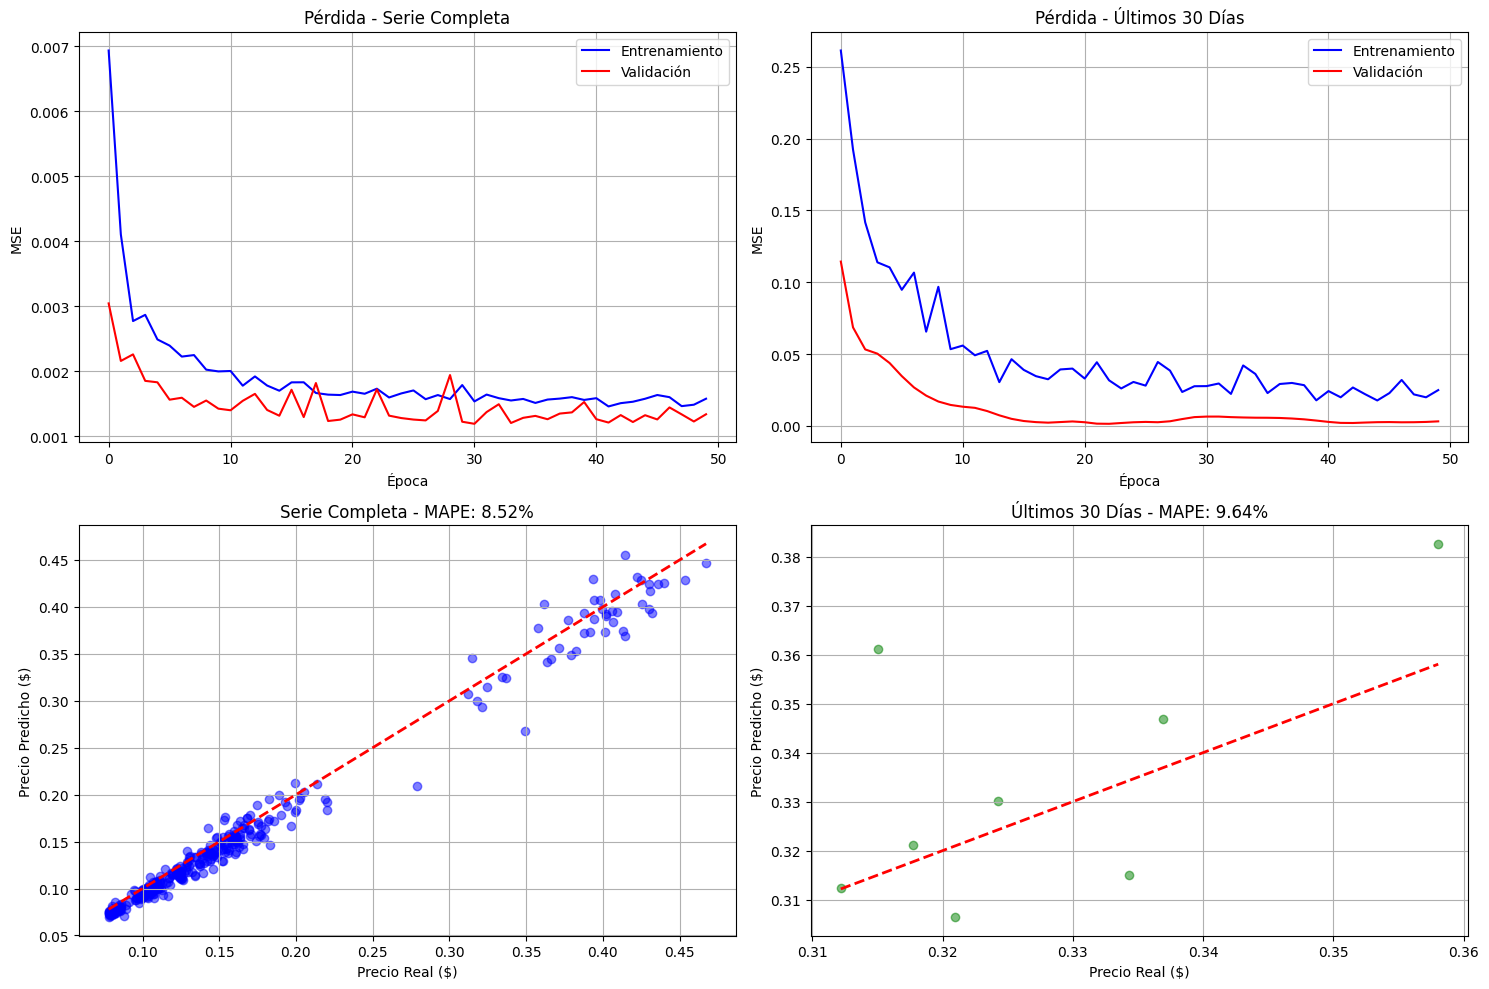

In [21]:
# ============================================================================
# 12. VISUALIZACIÓN DE RESULTADOS
# ============================================================================

plt.figure(figsize=(15, 10))

# Gráfico 1: Pérdida durante entrenamiento - Serie Completa
plt.subplot(2, 2, 1)
plt.plot(history_completo.history['loss'], label='Entrenamiento', color='blue')
plt.plot(history_completo.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida - Serie Completa')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# Gráfico 2: Pérdida durante entrenamiento - Últimos 30 días
plt.subplot(2, 2, 2)
plt.plot(history_reciente.history['loss'], label='Entrenamiento', color='blue')
plt.plot(history_reciente.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida - Últimos 30 Días')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# Gráfico 3: Predicciones vs Reales - Serie Completa
plt.subplot(2, 2, 3)
plt.scatter(resultados_completo['y_real'][:, 0], resultados_completo['y_pred'][:, 0], 
           alpha=0.5, color='blue')
plt.plot([resultados_completo['y_real'][:, 0].min(), resultados_completo['y_real'][:, 0].max()], 
         [resultados_completo['y_real'][:, 0].min(), resultados_completo['y_real'][:, 0].max()], 
         'r--', lw=2)
plt.xlabel('Precio Real ($)')
plt.ylabel('Precio Predicho ($)')
plt.title(f'Serie Completa - MAPE: {resultados_completo["mape"]:.2f}%')
plt.grid(True)

# Gráfico 4: Predicciones vs Reales - Últimos 30 días
plt.subplot(2, 2, 4)
plt.scatter(resultados_reciente['y_real'][:, 0], resultados_reciente['y_pred'][:, 0], 
           alpha=0.5, color='green')
plt.plot([resultados_reciente['y_real'][:, 0].min(), resultados_reciente['y_real'][:, 0].max()], 
         [resultados_reciente['y_real'][:, 0].min(), resultados_reciente['y_real'][:, 0].max()], 
         'r--', lw=2)
plt.xlabel('Precio Real ($)')
plt.ylabel('Precio Predicho ($)')
plt.title(f'Últimos 30 Días - MAPE: {resultados_reciente["mape"]:.2f}%')
plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
# ============================================================================
# 13. PREDICCIÓN FUTURA
# ============================================================================

print(f"\n🔮 PREDICCIÓN PARA LOS PRÓXIMOS 6 DÍAS")
print("="*60)

# Tomamos los últimos días para hacer predicción
ultimos_dias = precios_normalizados[-DIAS_HISTORICOS:].reshape(1, DIAS_HISTORICOS, 1)

# Predicción con modelo de serie completa
pred_futura_completa = modelo_completo.predict(ultimos_dias, verbose=0)
pred_futura_completa_real = scaler.inverse_transform(pred_futura_completa.reshape(-1, 1))

# Predicción con modelo de últimos 30 días
pred_futura_reciente = modelo_reciente.predict(ultimos_dias, verbose=0)
pred_futura_reciente_real = scaler.inverse_transform(pred_futura_reciente.reshape(-1, 1))

print(f"🔄 PREDICCIONES MODELO SERIE COMPLETA:")
for i, precio in enumerate(pred_futura_completa_real.flatten(), 1):
    print(f"   Día +{i}: ${precio:.6f}")

print(f"\n🔄 PREDICCIONES MODELO ÚLTIMOS 30 DÍAS:")
for i, precio in enumerate(pred_futura_reciente_real.flatten(), 1):
    print(f"   Día +{i}: ${precio:.6f}")

print(f"\n💡 CONSEJOS PARA AJUSTAR DÍAS DE PREDICCIÓN:")
print(f"   🔧 Para cambiar días de predicción, modifica esta línea:")
print(f"      DIAS_PREDICCION = {DIAS_PREDICCION}  # ← CAMBIA ESTE NÚMERO")
print(f"   📊 Más días (ej: 10, 15): Predicciones más largas pero menos precisas")
print(f"   📊 Menos días (ej: 3, 1): Predicciones más cortas pero más precisas")
print(f"   ⚠️  IMPORTANTE: Si cambias DIAS_PREDICCION, debes RE-ENTRENAR el modelo")

print(f"\n💡 CONSEJOS PARA AJUSTAR DÍAS HISTÓRICOS:")
print(f"   🔧 Para cambiar días históricos, modifica esta línea:")
print(f"      DIAS_HISTORICOS = {DIAS_HISTORICOS}  # ← CAMBIA ESTE NÚMERO")
print(f"   📊 Más días históricos (ej: 30, 60): Más contexto pero más lento")
print(f"   📊 Menos días históricos (ej: 7, 10): Menos contexto pero más rápido")
print(f"   ⚠️  IMPORTANTE: Si cambias DIAS_HISTORICOS, debes RE-ENTRENAR el modelo")

print(f"\n💡 CONSEJOS PARA MEJORAR EL LEARNING RATE:")
print(f"   🔧 Para cambiar learning rate, modifica esta línea:")
print(f"      LEARNING_RATE = {LEARNING_RATE}  # ← CAMBIA ESTE NÚMERO")
print(f"   - Si la pérdida no baja: AUMENTA el learning rate (ej: {LEARNING_RATE*10})")
print(f"   - Si la pérdida oscila mucho: DISMINUYE el learning rate (ej: {LEARNING_RATE/10})")
print(f"   - Learning rate actual: {LEARNING_RATE}")

print(f"\n✅ ¡NEURONA RNN COMPLETADA CON FECHAS!")
print(f"📊 Variable objetivo: CLOSE")
print(f"📊 Métrica MAPE incluida")
print(f"📊 Dos entrenamientos realizados")
print(f"📅 Fechas futuras incluidas")


🔮 PREDICCIÓN PARA LOS PRÓXIMOS 6 DÍAS
🔄 PREDICCIONES MODELO SERIE COMPLETA:
   Día +1: $0.305146
   Día +2: $0.313607
   Día +3: $0.302010
   Día +4: $0.298763
   Día +5: $0.299923
   Día +6: $0.289617

🔄 PREDICCIONES MODELO ÚLTIMOS 30 DÍAS:
   Día +1: $0.331611
   Día +2: $0.339704
   Día +3: $0.298334
   Día +4: $0.220332
   Día +5: $0.301972
   Día +6: $0.300230

💡 CONSEJOS PARA AJUSTAR DÍAS DE PREDICCIÓN:
   🔧 Para cambiar días de predicción, modifica esta línea:
      DIAS_PREDICCION = 6  # ← CAMBIA ESTE NÚMERO
   📊 Más días (ej: 10, 15): Predicciones más largas pero menos precisas
   📊 Menos días (ej: 3, 1): Predicciones más cortas pero más precisas
   ⚠️  IMPORTANTE: Si cambias DIAS_PREDICCION, debes RE-ENTRENAR el modelo

💡 CONSEJOS PARA AJUSTAR DÍAS HISTÓRICOS:
   🔧 Para cambiar días históricos, modifica esta línea:
      DIAS_HISTORICOS = 30  # ← CAMBIA ESTE NÚMERO
   📊 Más días históricos (ej: 30, 60): Más contexto pero más lento
   📊 Menos días históricos (ej: 7, 10): Meno

In [24]:
# ============================================================================
# 13. PREDICCIÓN FUTURA
# ============================================================================

print(f"\n🔮 PREDICCIÓN PARA LOS PRÓXIMOS 6 DÍAS")
print("="*60)

# Tomamos los últimos días para hacer predicción
ultimos_dias = precios_normalizados[-DIAS_HISTORICOS:].reshape(1, DIAS_HISTORICOS, 1)

# Predicción con modelo de serie completa
pred_futura_completa = modelo_completo.predict(ultimos_dias, verbose=0)
pred_futura_completa_real = scaler.inverse_transform(pred_futura_completa.reshape(-1, 1))

# Predicción con modelo de últimos 30 días
pred_futura_reciente = modelo_reciente.predict(ultimos_dias, verbose=0)
pred_futura_reciente_real = scaler.inverse_transform(pred_futura_reciente.reshape(-1, 1))

print(f"🔄 PREDICCIONES MODELO SERIE COMPLETA:")
for i, precio in enumerate(pred_futura_completa_real.flatten(), 1):
    print(f"   Día +{i}: ${precio:.6f}")

print(f"\n🔄 PREDICCIONES MODELO ÚLTIMOS 30 DÍAS:")
for i, precio in enumerate(pred_futura_reciente_real.flatten(), 1):
    print(f"   Día +{i}: ${precio:.6f}")

print(f"\n💡 CONSEJOS PARA AJUSTAR DÍAS DE PREDICCIÓN:")
print(f"   🔧 Para cambiar días de predicción, modifica esta línea:")
print(f"      DIAS_PREDICCION = {DIAS_PREDICCION}  # ← CAMBIA ESTE NÚMERO")
print(f"   📊 Más días (ej: 10, 15): Predicciones más largas pero menos precisas")
print(f"   📊 Menos días (ej: 3, 1): Predicciones más cortas pero más precisas")
print(f"   ⚠️  IMPORTANTE: Si cambias DIAS_PREDICCION, debes RE-ENTRENAR el modelo")

print(f"\n💡 CONSEJOS PARA AJUSTAR DÍAS HISTÓRICOS:")
print(f"   🔧 Para cambiar días históricos, modifica esta línea:")
print(f"      DIAS_HISTORICOS = {DIAS_HISTORICOS}  # ← CAMBIA ESTE NÚMERO")
print(f"   📊 Más días históricos (ej: 30, 60): Más contexto pero más lento")
print(f"   📊 Menos días históricos (ej: 7, 10): Menos contexto pero más rápido")
print(f"   ⚠️  IMPORTANTE: Si cambias DIAS_HISTORICOS, debes RE-ENTRENAR el modelo")

print(f"\n💡 CONSEJOS PARA MEJORAR EL LEARNING RATE:")
print(f"   🔧 Para cambiar learning rate, modifica esta línea:")
print(f"      LEARNING_RATE = {LEARNING_RATE}  # ← CAMBIA ESTE NÚMERO")
print(f"   - Si la pérdida no baja: AUMENTA el learning rate (ej: {LEARNING_RATE*10})")
print(f"   - Si la pérdida oscila mucho: DISMINUYE el learning rate (ej: {LEARNING_RATE/10})")
print(f"   - Learning rate actual: {LEARNING_RATE}")

print(f"\n✅ ¡NEURONA RNN COMPLETADA CON FECHAS!")
print(f"📊 Variable objetivo: CLOSE")
print(f"📊 Métrica MAPE incluida")
print(f"📊 Dos entrenamientos realizados")
print(f"📅 Fechas futuras incluidas")


🔮 PREDICCIÓN PARA LOS PRÓXIMOS 6 DÍAS
🔄 PREDICCIONES MODELO SERIE COMPLETA:
   Día +1: $0.305146
   Día +2: $0.313607
   Día +3: $0.302010
   Día +4: $0.298763
   Día +5: $0.299923
   Día +6: $0.289617

🔄 PREDICCIONES MODELO ÚLTIMOS 30 DÍAS:
   Día +1: $0.331611
   Día +2: $0.339704
   Día +3: $0.298334
   Día +4: $0.220332
   Día +5: $0.301972
   Día +6: $0.300230

💡 CONSEJOS PARA AJUSTAR DÍAS DE PREDICCIÓN:
   🔧 Para cambiar días de predicción, modifica esta línea:
      DIAS_PREDICCION = 6  # ← CAMBIA ESTE NÚMERO
   📊 Más días (ej: 10, 15): Predicciones más largas pero menos precisas
   📊 Menos días (ej: 3, 1): Predicciones más cortas pero más precisas
   ⚠️  IMPORTANTE: Si cambias DIAS_PREDICCION, debes RE-ENTRENAR el modelo

💡 CONSEJOS PARA AJUSTAR DÍAS HISTÓRICOS:
   🔧 Para cambiar días históricos, modifica esta línea:
      DIAS_HISTORICOS = 30  # ← CAMBIA ESTE NÚMERO
   📊 Más días históricos (ej: 30, 60): Más contexto pero más lento
   📊 Menos días históricos (ej: 7, 10): Meno

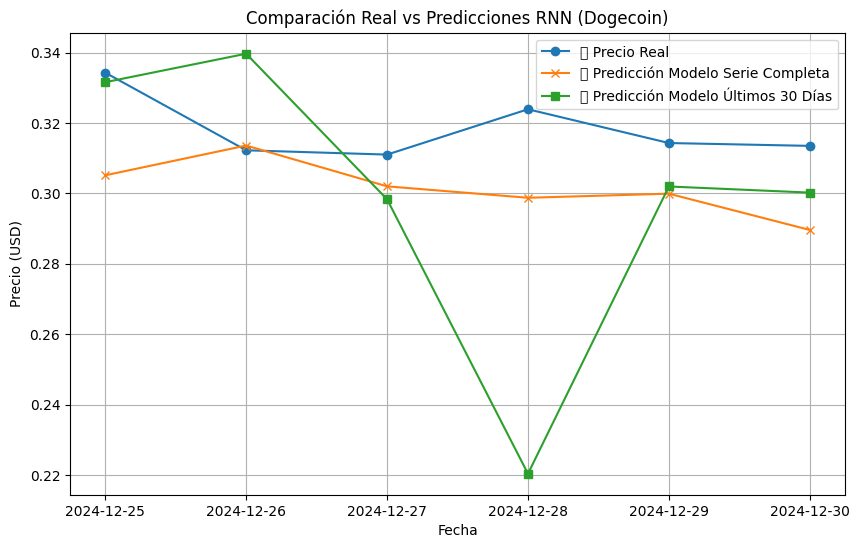


📊 MÉTRICAS DE ERROR (últimos días)
MAE Modelo Serie Completa: 0.017167
MAE Modelo Últimos 30 Días: 0.028680
RMSE Modelo Serie Completa: 0.019772
RMSE Modelo Últimos 30 Días: 0.044687


In [25]:
import matplotlib.pyplot as plt
import numpy as np

# ========================================================================
# 14. COMPARACIÓN CON DATOS REALES
# ========================================================================

# Tomamos los últimos N días reales (los mismos que predices)
dias_a_comparar = DIAS_PREDICCION  
reales = df['Close'].values[-dias_a_comparar:]  # últimos precios reales

# Creamos vector de días para graficar
fechas_reales = df.index[-dias_a_comparar:]

# Predicciones ya obtenidas (del bloque anterior)
pred_completa = pred_futura_completa_real.flatten()
pred_reciente = pred_futura_reciente_real.flatten()

# Gráfico
plt.figure(figsize=(10,6))
plt.plot(fechas_reales, reales, label="📈 Precio Real", marker="o")
plt.plot(fechas_reales, pred_completa, label="🤖 Predicción Modelo Serie Completa", marker="x")
plt.plot(fechas_reales, pred_reciente, label="🤖 Predicción Modelo Últimos 30 Días", marker="s")

plt.title("Comparación Real vs Predicciones RNN (Dogecoin)")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Métricas de error para cuantificar desempeño
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_completa = mean_absolute_error(reales, pred_completa)
mae_reciente = mean_absolute_error(reales, pred_reciente)

print("\n📊 MÉTRICAS DE ERROR (últimos días)")
print(f"MAE Modelo Serie Completa: {mae_completa:.6f}")
print(f"MAE Modelo Últimos 30 Días: {mae_reciente:.6f}")
print(f"RMSE Modelo Serie Completa: {np.sqrt(mean_squared_error(reales, pred_completa)):.6f}")
print(f"RMSE Modelo Últimos 30 Días: {np.sqrt(mean_squared_error(reales, pred_reciente)):.6f}")


In [26]:
import pandas as pd

# ========================================================================
# 15. TABLA COMPARATIVA REAL vs PREDICCIONES
# ========================================================================

# Creamos DataFrame con comparación
tabla_comparativa = pd.DataFrame({
    "Fecha": fechas_reales,
    "Precio Real (USD)": reales,
    "Predicción Serie Completa (USD)": pred_completa,
    "Predicción Últimos 30 Días (USD)": pred_reciente,
    "Error Serie Completa": reales - pred_completa,
    "Error Últimos 30 Días": reales - pred_reciente
})

# Redondeamos valores para presentación
tabla_comparativa = tabla_comparativa.round(6)

# Mostrar tabla
import IPython.display as display
display.display(tabla_comparativa)

# También la puedes exportar a Excel
tabla_comparativa.to_excel("comparacion_predicciones.xlsx", index=False)
print("\n📊 Tabla comparativa exportada a 'comparacion_predicciones.xlsx'")


ValueError: Per-column arrays must each be 1-dimensional